<h1>Open_Seg2_Apply_Geo_Cal</h1>
<p>by Farnyuh Menq</p>
<p>NHERI@UTexas site Manager</p>
<p>2017/2/1</p>
<p>This notebook open a seg2 data file, apply geophone calibrtion factor and plot the time records in a waterfall plot.</p>

In [1]:
# import all the libraries needed
%matplotlib inline
import matplotlib.pyplot as plt
from obspy.io.seg2.seg2 import _is_seg2
from obspy.io.seg2.seg2 import _read_seg2
import numpy as np
import math

<h1>Step 1: Import calibration factors from an csv file. </h1>

In [9]:
folder = r'C:\Users\Farnyuh Menq\Desktop\Static\3D vis Levee\From Joe'
folder = folder + '\\'
filename =  'Pmode_cal_file.csv'
# Read csv file 
Cal_Fac = np.genfromtxt(folder + filename, delimiter=',', skip_header=1)
print (Cal_Fac)

[[   4.80631984    2.05568905    0.67638437 ...,           nan    1.
            nan]
 [   4.80631984    2.05568905    0.67638437 ...,           nan    2.
            nan]
 [   4.80631984    2.05568905    0.67638437 ...,           nan    3.
            nan]
 ..., 
 [          nan           nan           nan ...,           nan  214.
            nan]
 [          nan           nan           nan ...,           nan  215.
            nan]
 [          nan           nan           nan ...,           nan  216.
            nan]]


In [24]:
fn = Cal_Fac[:, 0]
G = Cal_Fac[:, 1]
D = Cal_Fac[:, 2]
Polarity = Cal_Fac[:, 3]
DAS_Gain = 10.0**(Cal_Fac[:, 4] / 20.0)
N_Geophone = np.argwhere(np.isnan(Cal_Fac[:,0]))[0]
print (N_Geophone)

[192]


<h1>Step 2: Open and Plot the seg2 data file</h1>

C:\Program Files\Anaconda3\lib\site-packages\obspy\io\seg2\seg2.py:277: UserWarning: Non-zero value found in Trace's 'DELAY' field. This is not supported/tested yet and might lead to a wrong starttime of the Trace. Please contact the ObsPy developers with a sample file.
  warnings.warn(msg)
C:\Program Files\Anaconda3\lib\site-packages\obspy\io\seg2\seg2.py:388: UserWarning: Many companies use custom defined SEG2 header variables. This might cause basic header information reflected in the single traces' stats to be wrong (e.g. recording delays, first sample number, station code names, ..). Please check the complete list of additional unmapped header fields that gets stored in Trace.stats.seg2 and/or the manual of the source of the SEG2 files for fields that might influence e.g. trace start times.
  warnings.warn(WARNING_HEADER)


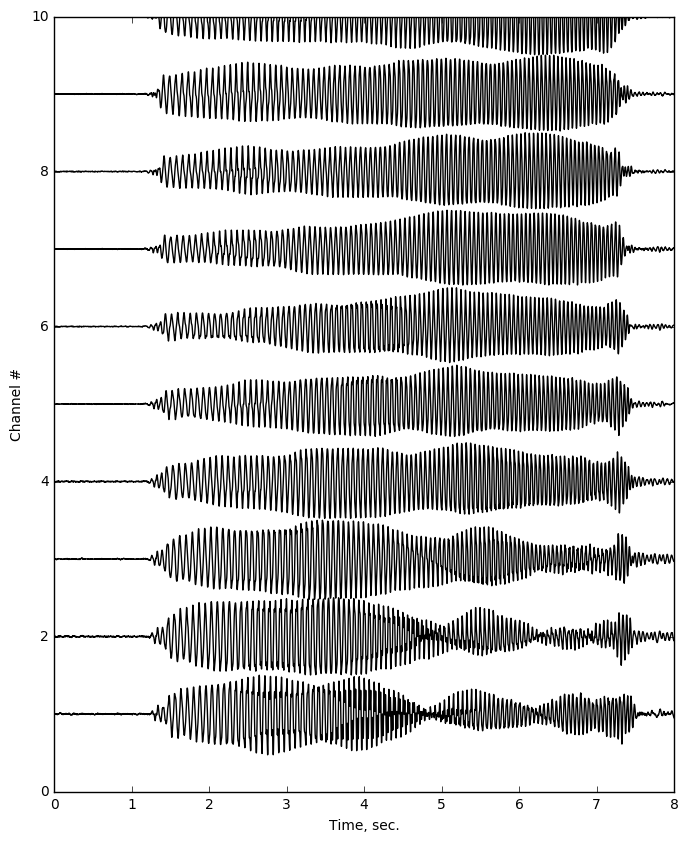

In [10]:
folder = r'C:\Users\Farnyuh Menq\Desktop\Static\3D vis Levee'
folder = folder + '\\'
filename =  '298.dat' # p-mode
# Read seg2 file using the obspy library
my_data = _read_seg2(folder + filename)

'''
print(my_data)                       # print out information of each channel
print(len(my_data))                  # print total number of channel in the file
print(my_data[0].data)               # print data in the fiest channel
print(my_data[0].stats.sampling_rate) # print sampling rate in channel 1
print(my_data[0].stats.npts)         # print number of point in channel 1
'''
# create a waterfall figure
fig = plt.figure()
fig.set_size_inches (8, 10)
ax = fig.add_subplot(111)

# setup time array
t = np.linspace(0,my_data[0].stats.npts / my_data[0].stats.sampling_rate,
                my_data[0].stats.npts)

offset = 0

for y in my_data:
    # Offset each line by the amount of offset
    # at the bottom of the chart and to work our way up
    offset = offset + 1.0
    # Plot the line 
    ax.plot(t,y.data/y.data.max()/2.0 + offset, 'k')
plt.ylim (0, 10)
plt.xlabel('Time, sec.')
plt.ylabel('Channel #')
plt.show()


<h1>Step 3: Define geophone calibration function.</h1>

In [29]:
def Apply_Geophone_Cal (dt, y, fn, G, D):
    '''
    Modified from Apply_Geophone_Cal.m MatLab Function
    # function [y1] = Apply_Geophone_Cal (dt, y, fn, G, D)
    # Apply geophone calibration spectrum on a time record 
    # By Farn-Yuh Menq and Clark R Wilson at NEES@UTexas 2012/2/14
    #
    # dt is delta time between data point 
    # y is the original time record
    # fn is the natural frequency of the geophone
    # G is the calibration factor (V/in.
    # D is damping ratio (not in #)
    # y1 is the time record with the applied calibration factors (including
    # amplitide and phase)
    #
    # This function transfer input time record (y) in to freq domain (Y), multiply
    # Y with the geophone calibration cruve (geo), and transfer it back to time
    # domain as y1.
    '''

    fs = 1.0/dt                    # Sampling frequency
    N = len(y)               # Length of signal
    #print (D)

    # FFT
    Y = (np.fft.fft(y))*2.0/N
    # frequency array
    #f = [0:1/dt/N:1/2/dt]
    f = np.linspace (0, fs/2, N/2+1)

    # Generate a Geophone response (calibration) curve
    geo_amp = np.zeros(N)  # geophone calibration curve amplitude
    geo_phs = np.zeros(N)  # geophone calibration curve phase
    geo = np.zeros((N), np.complex64)      # geophone calibration curve complex number
    Y_cal = np.zeros((N), np.complex64)      # applied FFT(y) / geo
    geo_amp= G * f**2/((fn**2-f**2)**2+(2*D*fn*f)**2)**0.5
    
    for j in range (0, int(N/2+1)):
        #geo_amp[j]= G * f[j]**2/((fn**2-f[j]**2)**2+(2*D*fn*f[j])**2)**0.5
        if (fn**2-f[j]**2) == 0:
            geo_phs[j]= -np.pi/2.0
        else:
            geo_phs[j]= -math.atan(2*D*fn*f[j]/(fn**2-f[j]**2))
        if geo_phs[j] > 0:
            geo_phs[j] = geo_phs[j] - np.pi
        geo[j] = geo_amp[j] * np.cos(geo_phs[j]) + geo_amp[j] * np.sin(geo_phs[j])*1j
        if j > 0: 
           geo[-j]= np.conj(geo[j])
        # Devide FFT Original signal with calibration factor - Transfer function
        if geo[j] != 0:
            Y_cal[j] = Y[j]/geo[j]
            Y_cal[-j] = Y[-j]/geo[-j]
        else:
            Y_cal[j] = 0.0
            Y_cal[-j] = 0.0

   
    # set 0 to first n_0 data points - geophones do not work well at low
    # frequency range
    n_0 = int(fn*0.1*fs)
    if n_0 ==0: n_0= 3
    if n_0 > 10: n_0 = 10
    for j in range (-n_0, n_0+1):
        Y_cal[j] = 0
    Y_cal[int(N/2)] = 0  # Set the value at the Nyquist frequency to 0 to ensure
    #no imagary part. 

    # Inverse FFT
    Y_cal = Y_cal * N/2.0
    y1=np.fft.ifft(Y_cal)
    if y1.imag.max() < 1e-10:
        y1 = y1.real
    return y1


<h1>Step 4: Apply Geophone calibration factor to each time record.</h1>

C:\Program Files\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


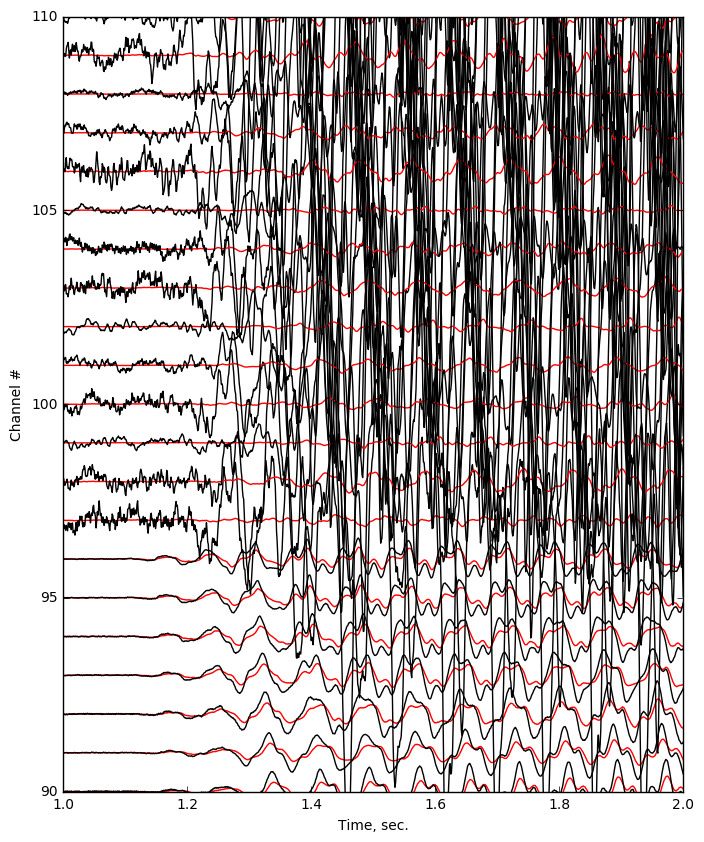

In [33]:
# create a waterfall figure
fig = plt.figure()
fig.set_size_inches (8, 10)
ax = fig.add_subplot(111)

offset = 0
i = 0
dt = 1.0 / my_data[0].stats.sampling_rate
for y in my_data:
    # Offset each line by the amount of offset
    # at the bottom of the chart and to work our way up
    offset = offset + 1.0
    # update calibration factor to account the gain setting of the DAS
    # G * DAS gain
    Cal_Fac_G = G[i] * DAS_Gain[i]#Cal_Fac[i, 1] * Cal_Fac[i, 4]
    # Plot the line 
    Y = Apply_Geophone_Cal(dt, y.data  * Polarity[i], # Cal_Fac[i, 1] is the polirity use "-1" for reverse
                           fn = Cal_Fac[i, 0], G = Cal_Fac_G, D = D[i])
    ax.plot(t, -Y / Y.max()/2.0 + offset, 'r', t,y.data/Y.max()/2.0 + offset, 'k')
    i = i + 1
    if i == 192:
        break
plt.xlim (1, 2)
plt.ylim (90, 110)
plt.xlabel('Time, sec.')
plt.ylabel('Channel #')
plt.show()